In [1]:
from cv2_images import CV2Image, cv2image_from_file, cv2image_from_pil, \
                            pil_to_cv2, cv2_to_pil

import pandas as pd
import os
from PIL.Image import Image
from PIL.ImageDraw import Draw
from PIL import ImageFont
import pytesseract

In [2]:
image_path = '/home/dchusov/temp_parsing_data/102/10.1021_acs.orglett.9b02412/ol9b02412_si_001.pdf_131.png' 

In [3]:
image_path_local = image_path.replace('/home/dchusov/temp_parsing_data', '/media/oleg/second_ssd/rxn_parsing_data')

image = cv2image_from_file(image_path_local)      


In [4]:
global_folder = '/media/oleg/second_ssd/rxn_parsing_data/102'
mol_df = pd.read_csv(os.path.join(global_folder, 'df_mols.csv'), sep = '\t')
sub_df = pd.read_csv(os.path.join(global_folder, 'df_subs.csv'), sep = '\t')

In [5]:
        mols = mol_df[mol_df['image_path'] == image_path]
        subs = sub_df[sub_df['image_path'] == image_path]

In [6]:
        mols.reset_index(inplace = True)
        subs.reset_index(inplace = True)

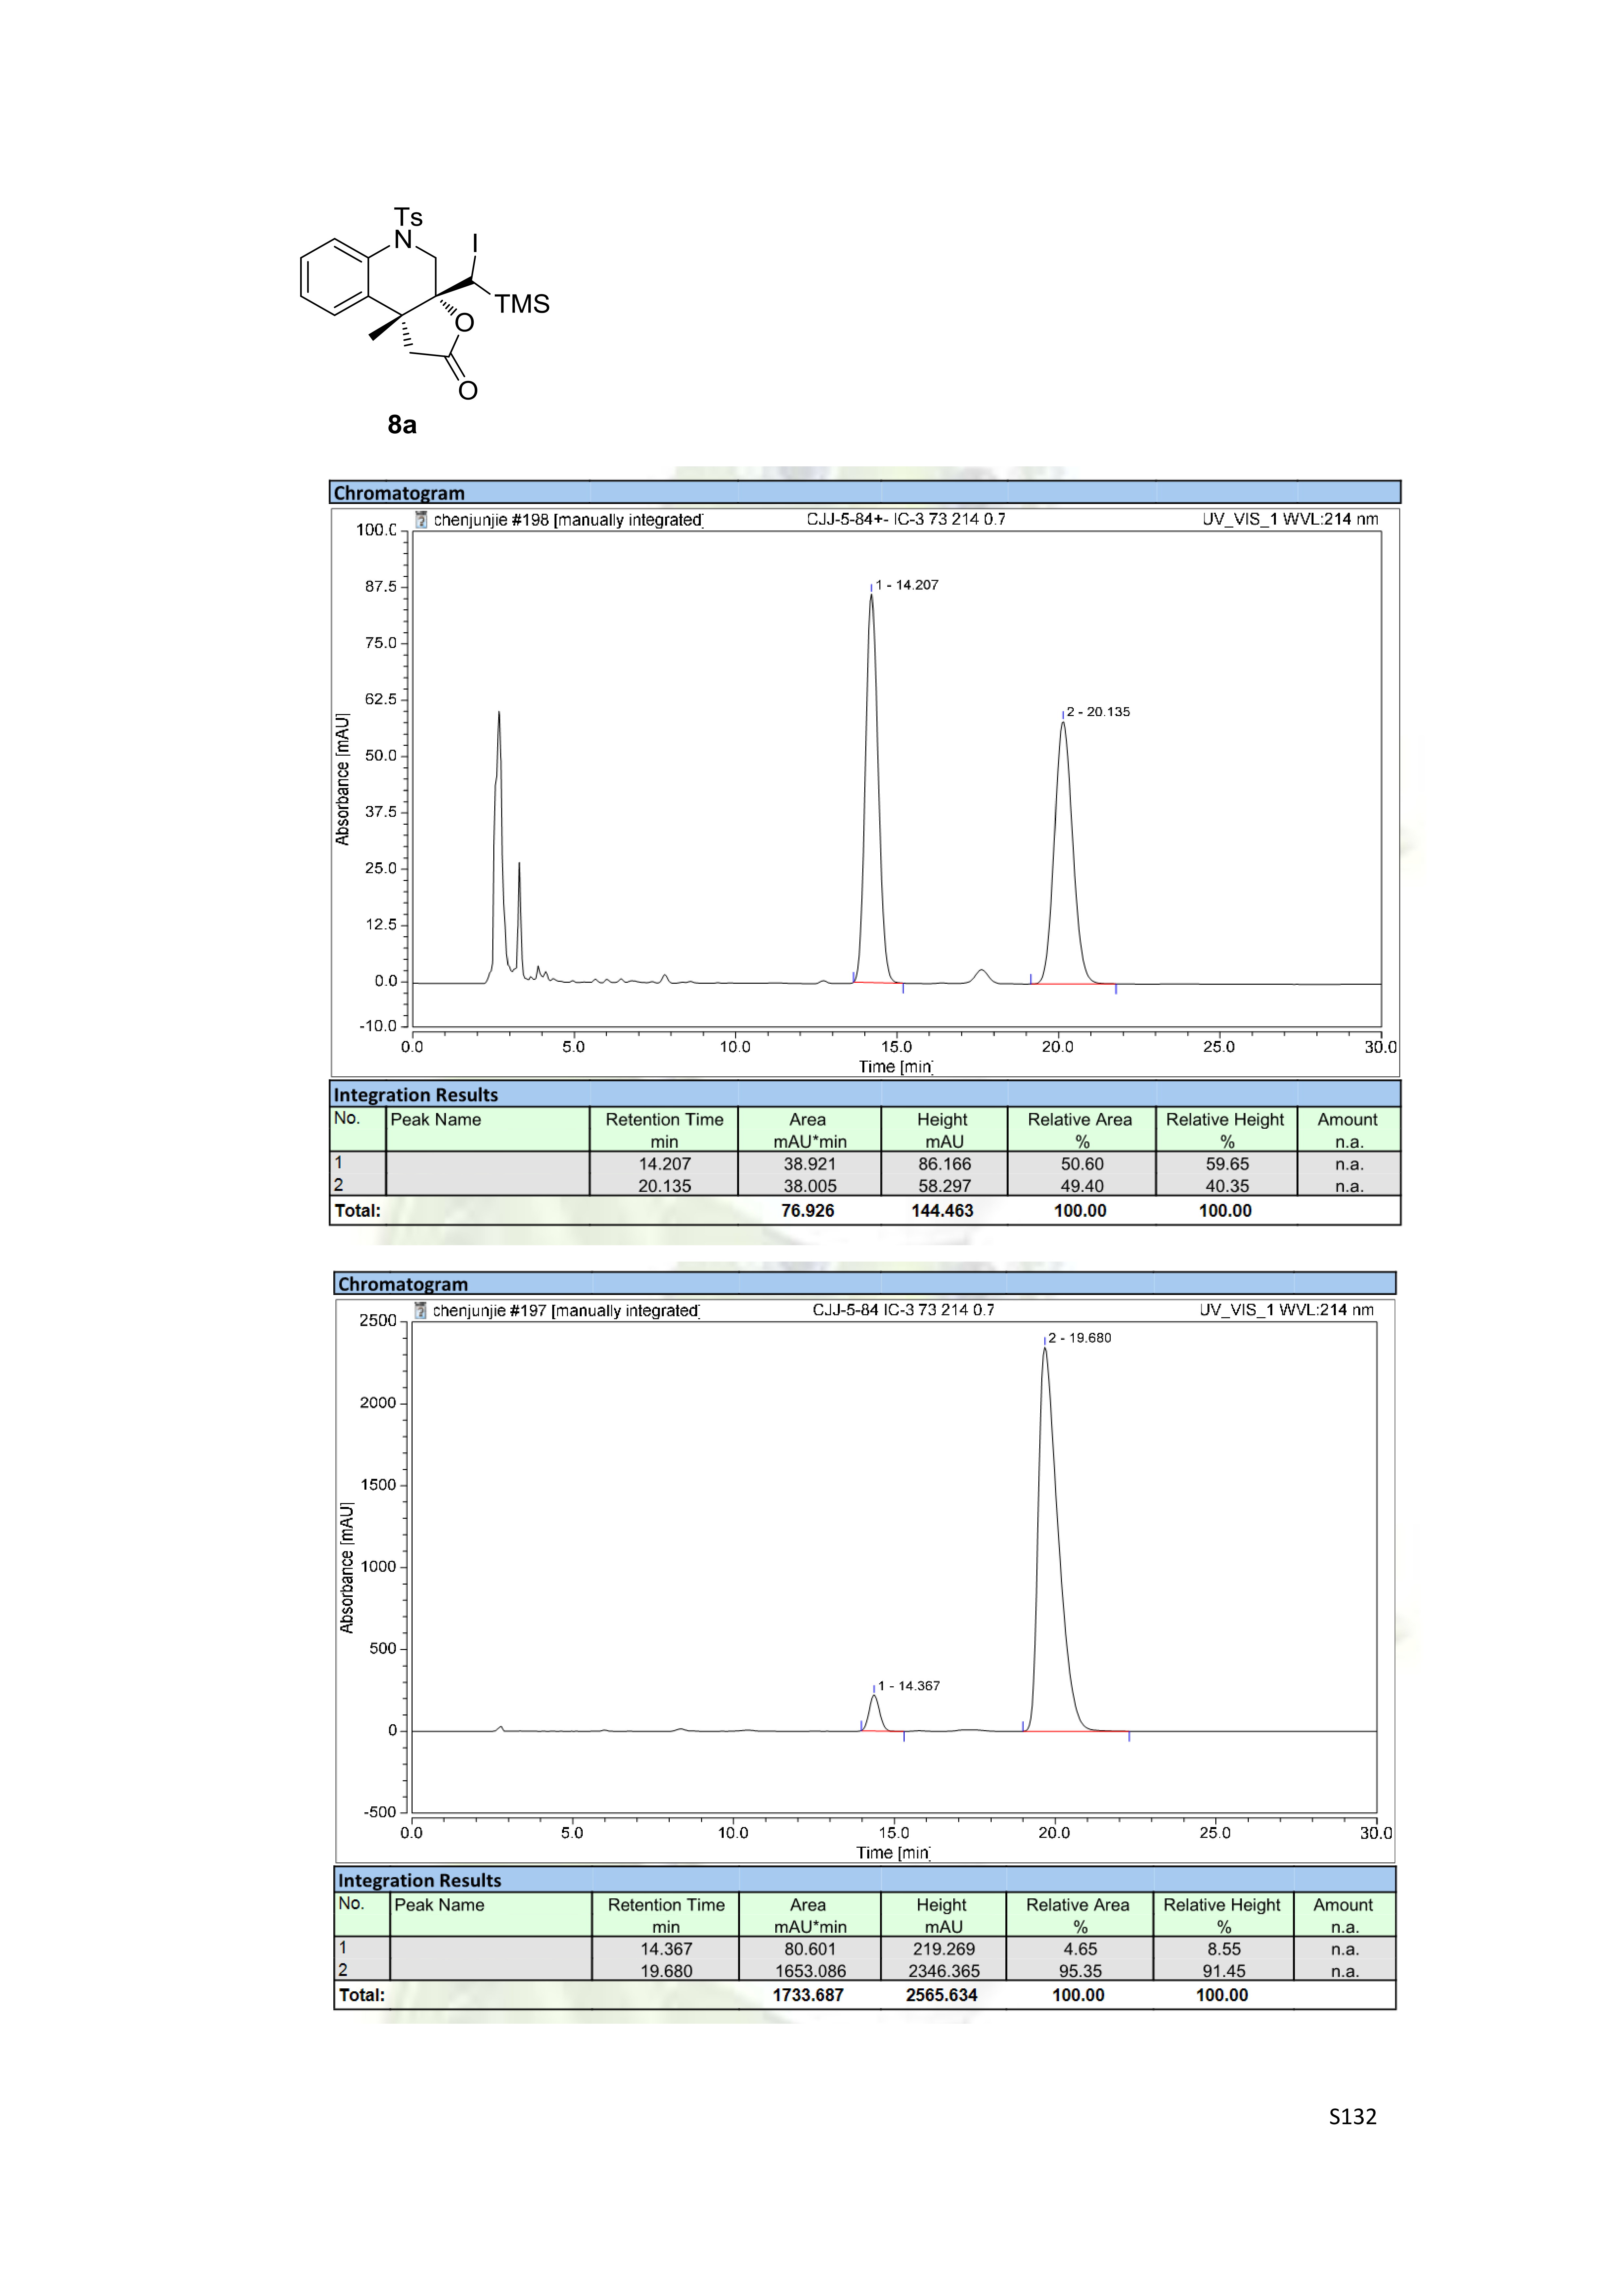

In [6]:
image.image

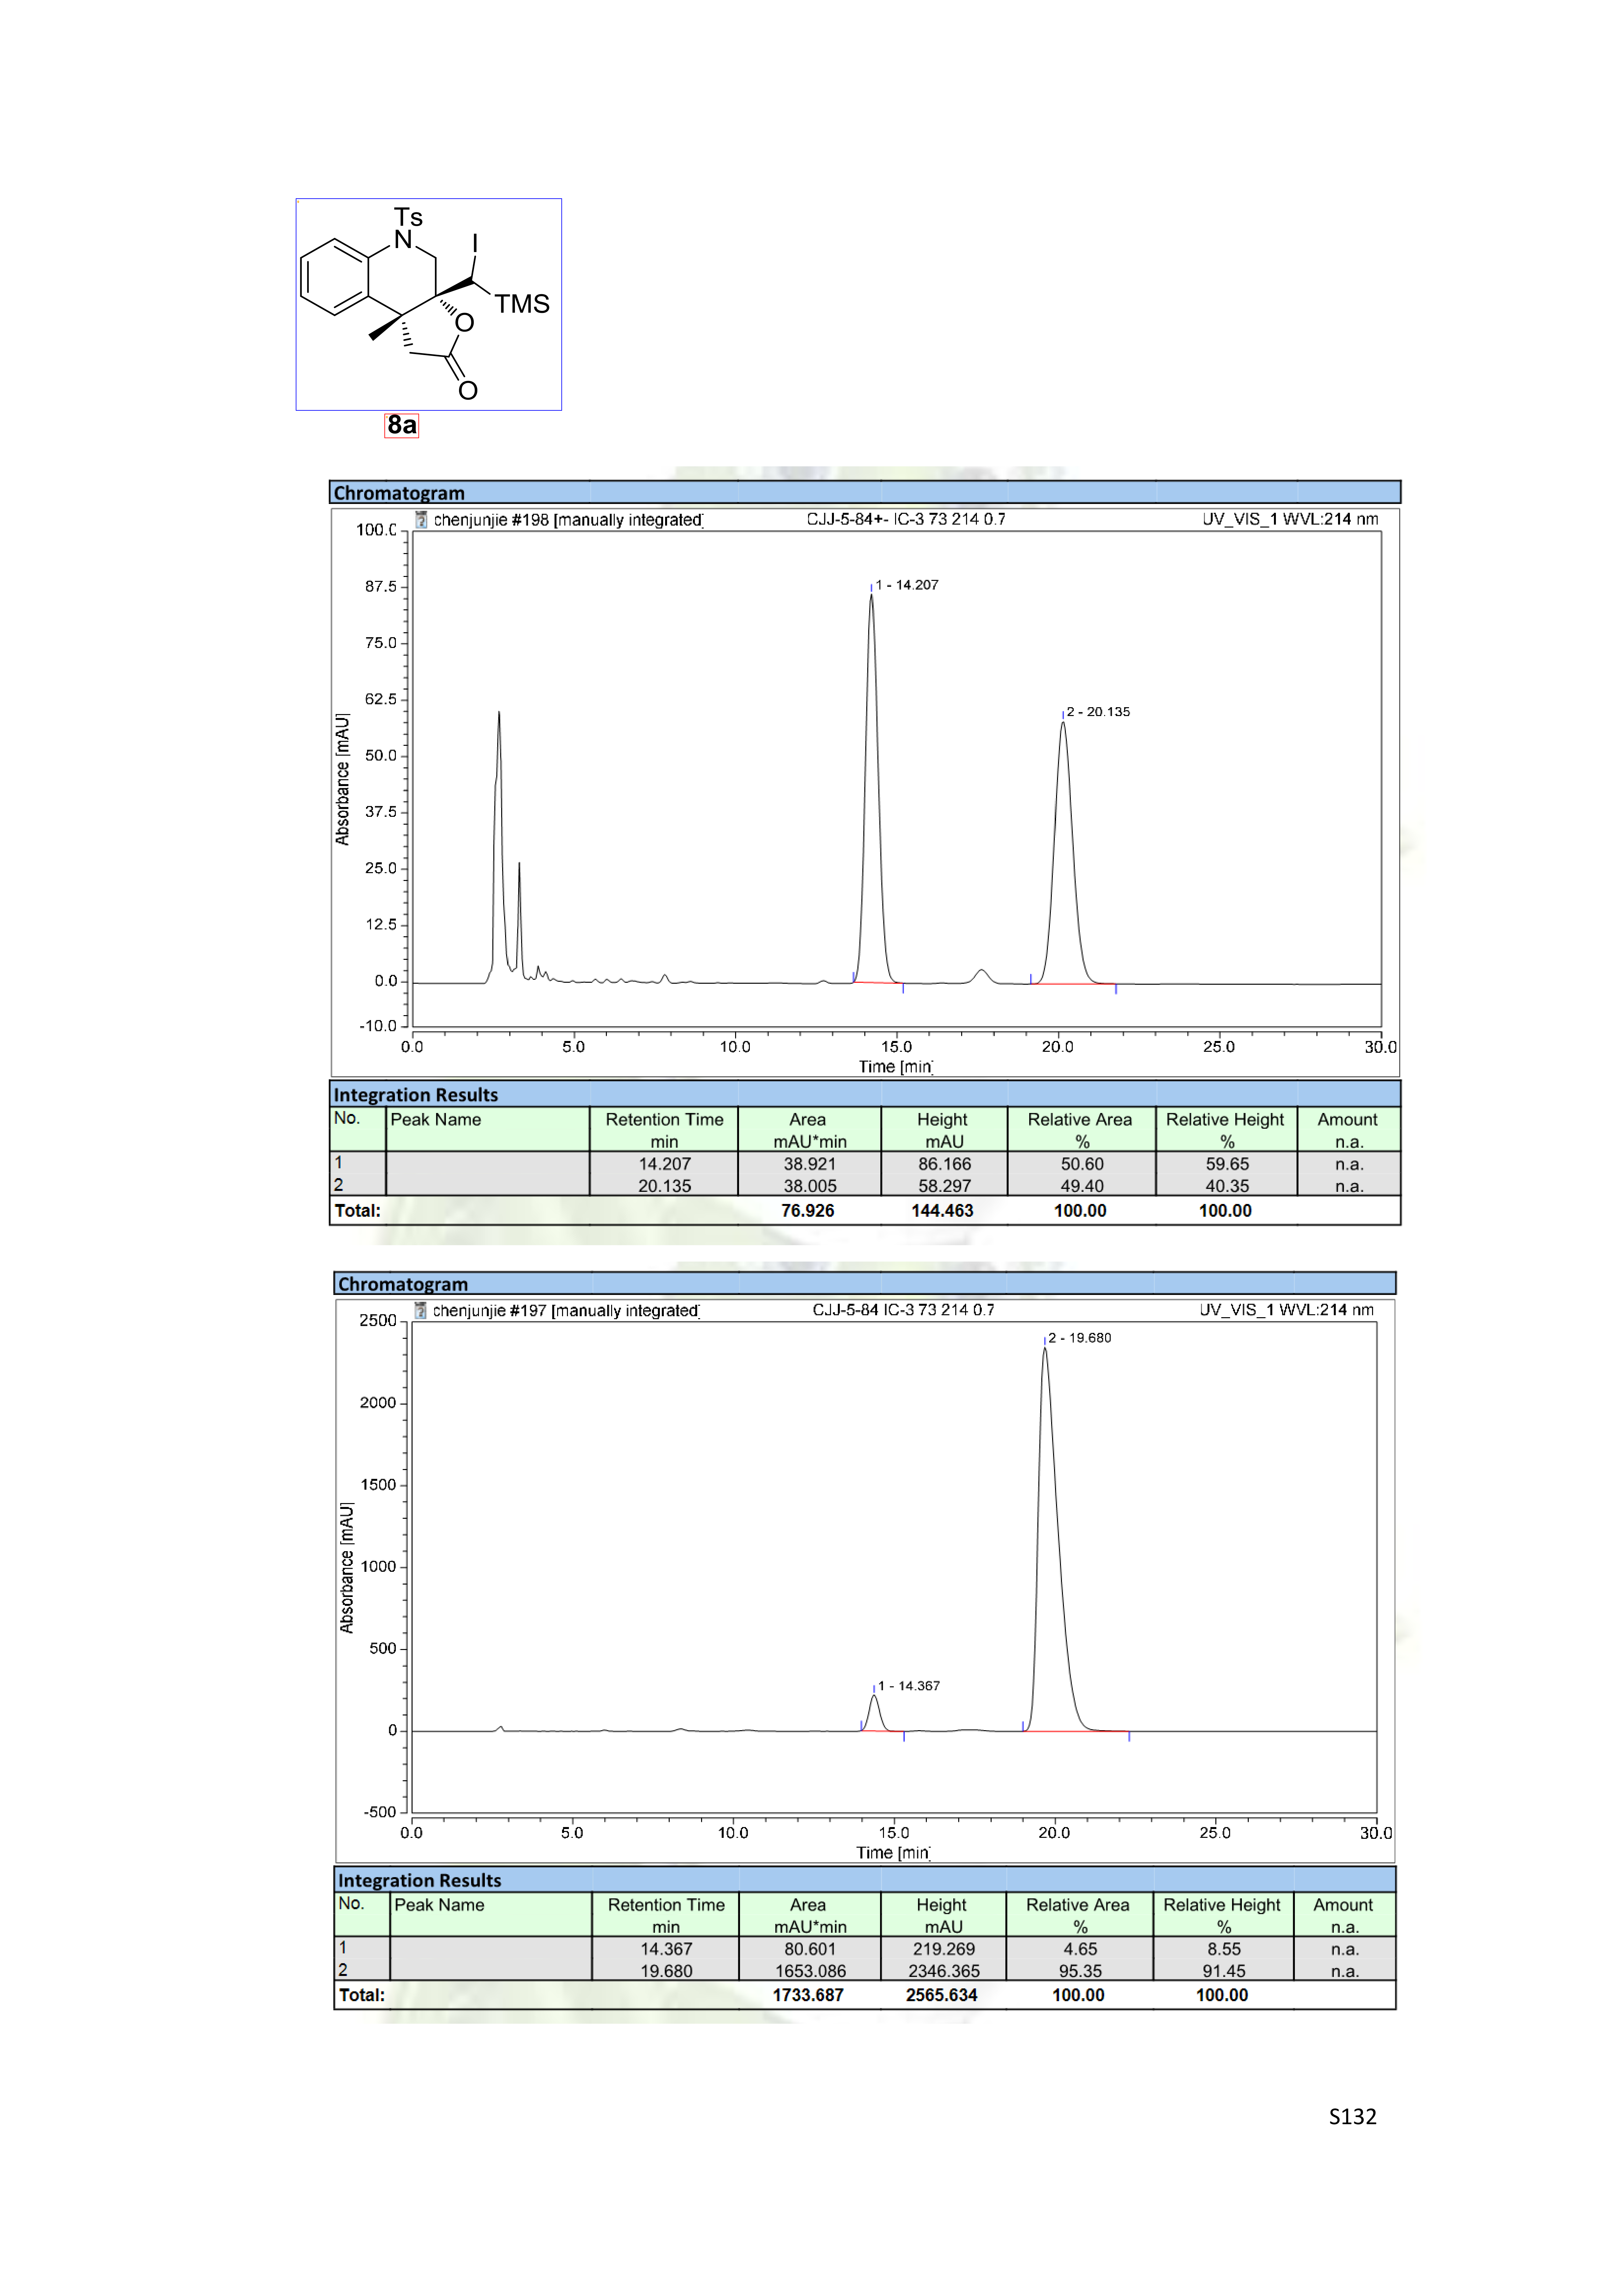

In [9]:
detected_objects(image, mols, subs)

In [7]:
    def detected_objects(image, mols, subs):
        '''Initial image with highlighted detected objects'''
        #for tessting only
        mapped_image = image.image.copy()
        draw = Draw(mapped_image)
#         font = ImageFont.load_default(16) # TODO: change to custom
        delta = 5
        for df, color in [(mols, 'blue'), (subs, 'red')]:
            for i in df.index:
                points = list(df.loc[i,['x1','y1','x2','y2']])
                draw.rectangle(points, outline=color, width=2)
                draw.text([_ + delta for _ in points[:2]], str(i), 
                          fill='orange', stroke_width=1, stroke_fill='orange')
        return mapped_image 

In [8]:
def recognize_text(image):
    '''Tesseract wrapper''' # HINT: https://muthu.co/all-tesseract-ocr-options/
    return pytesseract.image_to_string(image, config = '--psm 6')

def recognize_subscripts(init_image, subs):
    '''Recognizes detected subscripts'''
    if subs.empty:
        return
    # get images
    image = init_image.image
    cols = ['x1','y1','x2','y2']
    images = [pil_to_cv2(image.crop(subs.loc[i,cols])) for i in subs.index]
    # ocsr
    subs['text'] = pd.DataFrame({'text': [recognize_text(_) for _ in images]})
    subs['text'] = subs['text'].apply(lambda x: x.replace('\n', ' ').strip())
    return subs


In [10]:
recognize_subscripts(image, subs)

/tmp/ipykernel_934808/843902029.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['text'] = pd.DataFrame({'text': [recognize_text(_) for _ in images]})
/tmp/ipykernel_934808/843902029.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['text'] = subs['text'].apply(lambda x: x.replace('\n', ' ').strip())


,index,x1,y1,x2,y2,xcenter,ycenter,detection_confidence,image_path,text
0,18879,1175.550415,1264.730591,1280.529541,1338.366943,1228.039978,1301.548767,0.711882,/home/dchusov/temp_parsing_data/102/10.1021_ac...,8a


In [11]:
subs = recognize_subscripts(image, subs)

/tmp/ipykernel_934808/843902029.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['text'] = pd.DataFrame({'text': [recognize_text(_) for _ in images]})
/tmp/ipykernel_934808/843902029.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['text'] = subs['text'].apply(lambda x: x.replace('\n', ' ').strip())


In [12]:
subs

,index,x1,y1,x2,y2,xcenter,ycenter,detection_confidence,image_path,text
0,18879,1175.550415,1264.730591,1280.529541,1338.366943,1228.039978,1301.548767,0.711882,/home/dchusov/temp_parsing_data/102/10.1021_ac...,8a


In [ ]:
subs['text'] = subs['text'].apply(refine_subs)